In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorboard
from torch.utils.tensorboard import SummaryWriter

/home/shah/miniconda3/envs/rtx_3060/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [4]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 5796), started 1:41:15 ago. (Use '!kill 5796' to kill it.)

In [5]:
cudnn.benchmark = True
plt.ion()   # interactive mode
writer = SummaryWriter()

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])
}

path_dir = '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/data_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(path_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
                  
train_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
test_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=False, num_workers=0)
              for x in ['test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
#class_names = {k: v for v, k in enumerate(class_names)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(image_datasets)

In [31]:
class_names

['Appliances ',
 'Baby & Kids Stuff ',
 'Clothes, Footwear & Accessories ',
 'Computers & Software ',
 'DIY Tools & Materials ',
 'Health & Beauty ',
 'Home & Garden ',
 'Music, Films, Books & Games ',
 'Office Furniture & Equipment ',
 'Other Goods ',
 'Phones, Mobile Phones & Telecoms ',
 'Sports, Leisure & Travel ',
 'Video Games & Consoles ']

In [30]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 8108
    Root location: /home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/data_images/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

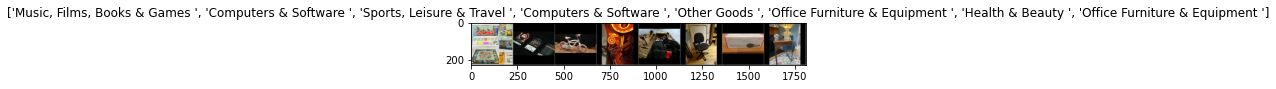

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, batch_size):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print("Training in progress")
                model.train()  
            elif phase == 'val':
                print("Validating in progress")
                model.eval()   
            
            num_corrects = 0
            num_samples = 0
            counter = 0

            # Iterate over data.
            for inputs, labels in train_dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                #with torch.set_grad_enabled(phase == 'train'):
                counter += 1
                predict = model(inputs)
                labels = labels
                _, preds = torch.max(predict, 1)
                loss = criterion(predict, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if counter % 10 == 9:
                    print(f'[{epoch + 1}, {counter + 1:5d}] loss: {loss}')
                    if phase == 'train':
                        writer.add_scalar('Training Loss', loss, epoch)
                    else:
                        writer.add_scalar('Validation Loss', loss, epoch)

                  
                num_corrects += torch.sum(preds == labels).sum()
                num_samples += preds.size(0)

            if phase == 'train':
                scheduler.step()
            
            acc = float(num_corrects) / num_samples

            print(f'Got {num_corrects} / {num_samples} with accuracy: {acc * 100}%')
            writer.add_scalar('Training Accuracy', acc, epoch)
            writer.add_scalar('Validation Accuracy', acc, epoch)
            # input("EPOCH COMPLETE: Press Enter to continue...")

            # deep copy the model
            if phase == 'val' and acc > best_acc:
                best_acc = acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/CNN.pt')
    return model

In [8]:
def test_accuracy(loader, model):

    model.eval()
    if loader == train_dataloaders['train']:
        print('Checking accuracy on training set..')
    else:
        print('Checking accuracy on evaluation set')
    label_correct = 0
    num_samples = 0
  
    with torch.no_grad(): 
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 

            num_samples += preds.size(0)
            label_correct += (preds == labels).sum()
        acc = float(label_correct) / num_samples

        print(f'Test Accuracy of the model: {label_correct}/ {num_samples} with accuracy of: {acc * 100}%')

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = models.resnet50(pretrained=True)
        for i, param in enumerate(self.features.parameters()):
            if i  < 47: #freeze 47 layers
                param.requires_grad = False
            else:
                param.requires_grad = True
        self.features.fc = nn.Sequential(
                nn.Linear(2048, 1024),    
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                #nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(128, 13))
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.reshape[0], -1)
        return x

In [ ]:
#from torchsummary import summary
#writer = SummaryWriter()
#model = models.resnet50(pretrained=True)
#summary(model, (3, 224, 224), device = 'cpu')

In [10]:
model = CNN().to(device) #Fine tune model
model_ft = model.features

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30, batch_size=8)

input("visualizing model")
test_accuracy(train_dataloaders['train'], model_ft)
test_accuracy(train_dataloaders['val'], model_ft)
writer.flush()
plt.ioff()
plt.show()

Epoch 1/30
----------
Training in progress
[1,    10] loss: 2.597126007080078
[1,    20] loss: 2.588656425476074
[1,    30] loss: 2.5685501098632812
[1,    40] loss: 2.5575122833251953
[1,    50] loss: 2.5467286109924316
[1,    60] loss: 2.529641628265381
[1,    70] loss: 2.520297050476074
[1,    80] loss: 2.5135385990142822
[1,    90] loss: 2.572355270385742
[1,   100] loss: 2.4942433834075928
[1,   110] loss: 2.561079263687134
[1,   120] loss: 2.5588297843933105
[1,   130] loss: 2.592216968536377
[1,   140] loss: 2.5132837295532227
[1,   150] loss: 2.6036911010742188
[1,   160] loss: 2.6303813457489014
[1,   170] loss: 2.5719940662384033
[1,   180] loss: 2.5853912830352783
[1,   190] loss: 2.47983980178833
[1,   200] loss: 2.609980821609497
[1,   210] loss: 2.501509428024292
[1,   220] loss: 2.5503311157226562
[1,   230] loss: 2.696589708328247
[1,   240] loss: 2.4289932250976562
[1,   250] loss: 2.516127586364746
[1,   260] loss: 2.5556552410125732
[1,   270] loss: 2.556125640869140

In [ ]:
#To save the model
#torch.save(model_ft, "data/image_model.pt")

#To load the model
#torch.load("data/image_model.pt")
#model.eval()

